<a href="https://colab.research.google.com/github/celineyayifeng/bayesianML/blob/main/Bayes_Final_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Bayesian Machine Learning Final Project**

### Hannah Lee, David Chen, Yayi Feng

In [ ]:
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as st
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.model_selection
from sklearn.model_selection import train_test_split

## **Data Cleaning**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data (1).csv


In [ ]:
data=pd.read_csv('data.csv')

In [ ]:
data.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [ ]:
data.drop('Unnamed: 32', axis=1, inplace=True)

In [ ]:
data.drop('id', axis=1, inplace=True)

In [ ]:
numerical_data = data.drop('diagnosis', axis=1)

### Scaling data

In [ ]:
from sklearn import preprocessing
cols = numerical_data.columns
np_numerical_data = np.asarray(numerical_data)
scaler = preprocessing.StandardScaler().fit(np_numerical_data)

In [ ]:
scaled = scaler.transform(np_numerical_data)

In [ ]:
cancer = pd.DataFrame(scaled, columns = cols)

In [ ]:
diag = (np.asarray(data['diagnosis']) == 'M').astype(int)

In [ ]:
cancer['diagnosis'] = diag

In [ ]:
cancer.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,2.489734,-0.565265,2.833031,2.487578,-0.214002,1.316862,0.724026,0.660820,1.148757,0.907083,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015,1
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,0.499255,-0.876244,0.263327,0.742402,-0.605351,-0.692926,-0.440780,0.260162,-0.805450,-0.099444,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190,1
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,1.228676,-0.780083,0.850928,1.181336,-0.297005,0.814974,0.213076,1.424827,0.237036,0.293559,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391,1
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,0.326373,-0.110409,0.286593,-0.288378,0.689702,2.744280,0.819518,1.115007,4.732680,2.047511,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010,1
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,1.270543,-0.790244,1.273189,1.190357,1.483067,-0.048520,0.828471,1.144205,-0.361092,0.499328,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100,1


### Split dataset into train and test sets

In [ ]:
np.random.seed(123)
train, test = train_test_split(cancer, test_size=0.30, random_state=42)

In [ ]:
cancer = train

In [ ]:
all_predictors = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']
y = cancer['diagnosis']
# No. of predictors 
k = len(all_predictors)

X = cancer[all_predictors]

In [ ]:
test_X = test[all_predictors]
test_y = test['diagnosis']

## **Bayesian Logistic Regression**

First, we will consider a full Bayesian Logistic Regression model.

In [ ]:
with pm.Model() as cancer_model: 

  # build the model with priors and run the sampling 
  data = pm.Data("data", X)

  # intercept term and prior 
  B0 = pm.Normal('B0', mu=0, sd=10)

  # beta coefficients for predictor variables and priors 

  B = pm.MvNormal('B', mu=np.zeros(k), cov=np.eye(k), shape=k)

  # calculate the logit 

  M = B0 + pm.math.dot(data, B)
  theta = pm.Deterministic('theta', pm.invlogit(M))
  
  # pass the logits to a Bernoulli outcome, with the observed data 
  Y = pm.Bernoulli('Y', p=theta, observed=y)

  # sample 
  trace_main = pm.sample(10000, cores=8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [B, B0]


Sampling 8 chains for 1_000 tune and 10_000 draw iterations (8_000 + 80_000 draws total) took 1929 seconds.


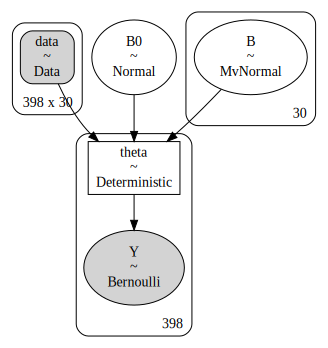

In [ ]:
pm.model_to_graphviz(cancer_model)

In [ ]:
# summary table
with cancer_model:
  main_idata = az.from_pymc3(trace_main)

az.summary(main_idata, var_names=['B0', 'B'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
B0,-0.32,0.44,-1.14,0.52,0.0,0.0,55219.28,54761.82,1.0
B[0],0.46,0.90,-1.27,2.13,0.0,0.0,67671.97,54587.84,1.0
B[1],0.45,0.57,-0.65,1.51,0.0,0.0,45946.65,49357.71,1.0
B[2],0.42,0.90,-1.28,2.10,0.0,0.0,68038.43,55792.49,1.0
B[3],0.54,0.92,-1.18,2.26,0.0,0.0,63307.65,52842.41,1.0
B[4],0.29,0.67,-0.98,1.54,0.0,0.0,60639.92,50915.46,1.0
B[5],-0.65,0.81,-2.19,0.88,0.0,0.0,60464.40,54636.32,1.0
B[6],0.86,0.83,-0.70,2.43,0.0,0.0,60848.91,51450.08,1.0
B[7],1.24,0.86,-0.39,2.85,0.0,0.0,66050.96,55414.62,1.0
B[8],-0.29,0.54,-1.30,0.73,0.0,0.0,63286.89,56456.62,1.0


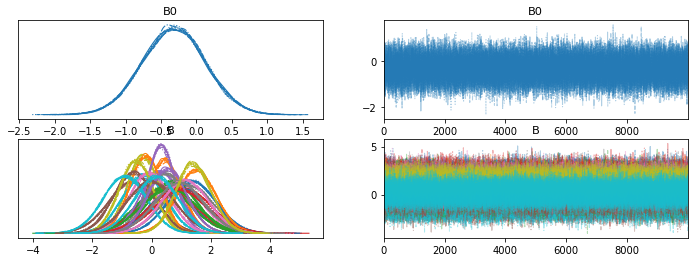

In [ ]:
# trace plots
with cancer_model:
  az.plot_trace(trace_main, var_names=['B0','B'])

Trace plots reveal that all beta coefficients converge to their respective mean values

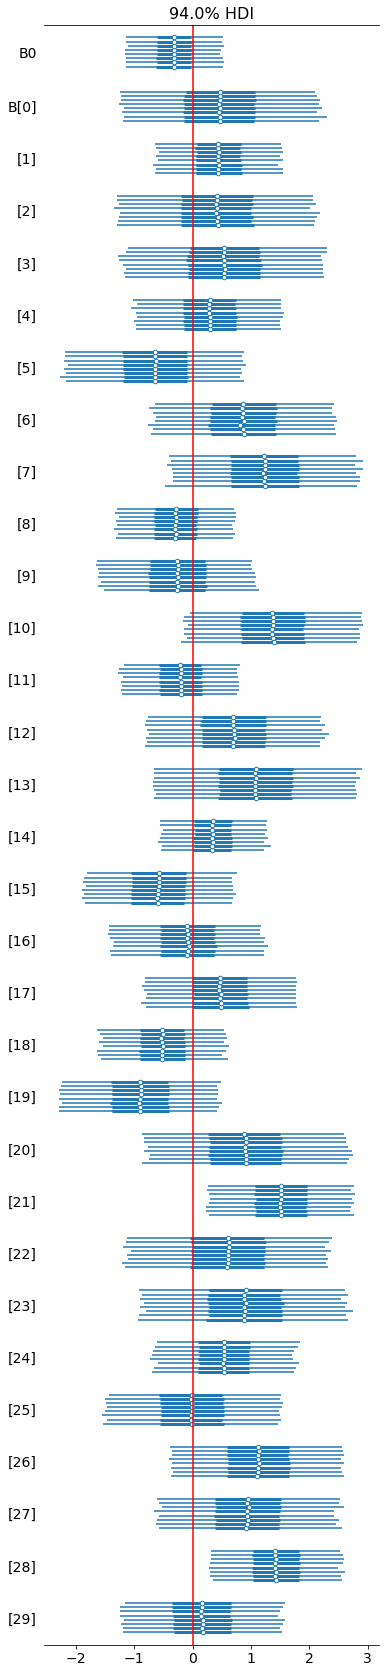

In [ ]:
# forest plots 
with cancer_model:
  pm.plot_forest(trace_main, var_names=['B0','B'])
  plt.axvline(color='r', linestyle='-')

In [ ]:
pd.DataFrame(all_predictors)

,0
0,radius_mean
1,texture_mean
2,perimeter_mean
3,area_mean
4,smoothness_mean
5,compactness_mean
6,concavity_mean
7,concave points_mean
8,symmetry_mean
9,fractal_dimension_mean


Based on the forest plot, all features except worst texture and worst symmetry are insignificant because the credible intervals overlap with 0.

## **Model 2**

Created by removing unuseful predictors based on the credible intervals overlapping 0 in the full model above.

In [ ]:
# Model 2

X_simple = X[['radius_mean','perimeter_mean','area_mean','smoothness_mean',
                   'symmetry_mean', 'fractal_dimension_mean', 'texture_mean', 'concavity_mean', 
                   'compactness_mean', 'concave points_mean']]

k_simple = X_simple.shape[1]

pd.DataFrame(X_simple)

,radius_mean,perimeter_mean,area_mean,smoothness_mean,symmetry_mean,fractal_dimension_mean,texture_mean,concavity_mean,compactness_mean,concave points_mean
149,-0.109996,-0.158542,-0.198772,-1.204139,-1.236277,-0.991984,-0.321053,-0.753164,-0.769070,-0.919018
124,-0.215082,-0.241747,-0.288361,-1.794101,-1.422476,-0.647506,-0.674768,-0.098925,-0.589220,-0.539588
421,0.159817,0.257479,0.003444,0.479635,1.001751,1.596561,-1.235591,0.705598,1.502076,0.363201
195,-0.345728,-0.388796,-0.393877,-1.206274,0.063458,-0.868652,-0.688730,-0.628619,-0.960480,-0.648697
545,-0.144078,-0.196849,-0.232332,-0.277565,-0.538947,-0.678694,0.916946,-0.741488,-0.698760,-0.631673
...,...,...,...,...,...,...,...,...,...,...
71,-1.488033,-1.366651,-1.168611,0.104593,0.329977,3.827870,-1.082004,-0.034392,0.924055,-0.521016
106,-0.706426,-0.691956,-0.689379,1.269571,-0.038768,0.340564,-0.223317,-0.227236,-0.050051,-0.362899
270,0.046211,-0.068748,-0.063392,-2.282296,-1.108494,-1.281175,-0.574704,-1.023849,-1.470464,-1.100607
435,-0.041833,-0.034972,-0.157532,0.686015,-0.520693,0.374586,0.076875,0.298817,0.169787,0.405245


In [ ]:
with pm.Model() as cancer_simple_model:
  
  data2 = pm.Data("data2", X_simple)

  beta0 = pm.Normal('beta0', mu=0, sd=10)
  beta = pm.MvNormal('beta', mu=np.zeros(k_simple), cov=np.eye(k_simple), shape=k_simple)

  mu = beta0 + pm.math.dot(data2, beta)
  theta = pm.Deterministic('theta', pm.invlogit(mu))

  Y = pm.Bernoulli('Y', p=theta, observed=y)

  trace_simple = pm.sample(10000, cores = 8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  del sys.path[0]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [beta, beta0]


Sampling 8 chains for 1_000 tune and 10_000 draw iterations (8_000 + 80_000 draws total) took 438 seconds.


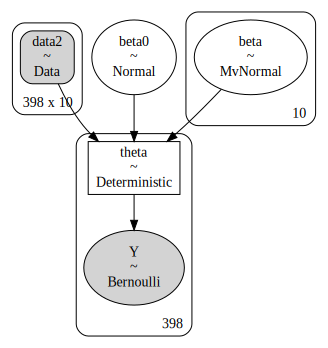

In [ ]:
pm.model_to_graphviz(cancer_simple_model)

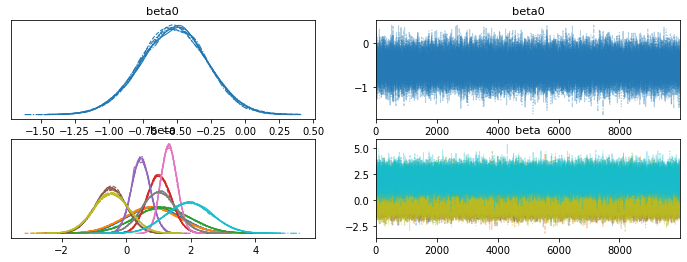

In [ ]:
# trace plots
with cancer_simple_model:
  az.plot_trace(trace_simple, var_names=['beta0','beta'])

In [ ]:
with cancer_simple_model:
  simple_idata = az.from_pymc3(trace_simple)
az.summary(simple_idata, var_names=['beta0','beta'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-0.52,0.24,-0.98,-0.06,0.0,0.0,80974.62,60410.32,1.0
beta[0],0.85,0.83,-0.72,2.38,0.0,0.0,72640.74,55081.83,1.0
beta[1],0.78,0.84,-0.80,2.37,0.0,0.0,76590.59,55184.12,1.0
beta[2],1.12,0.85,-0.46,2.74,0.0,0.0,74906.49,57424.74,1.0
beta[3],1.02,0.38,0.31,1.73,0.0,0.0,72828.01,60495.48,1.0
beta[4],0.46,0.29,-0.11,1.00,0.0,0.0,86460.15,56981.10,1.0
beta[5],-0.49,0.48,-1.40,0.41,0.0,0.0,68927.00,58323.99,1.0
beta[6],1.33,0.25,0.86,1.80,0.0,0.0,81384.97,59167.36,1.0
beta[7],1.02,0.53,0.04,2.02,0.0,0.0,68977.27,57935.12,1.0
beta[8],-0.46,0.55,-1.49,0.57,0.0,0.0,74282.08,56670.85,1.0


<Figure size 432x1008 with 0 Axes>

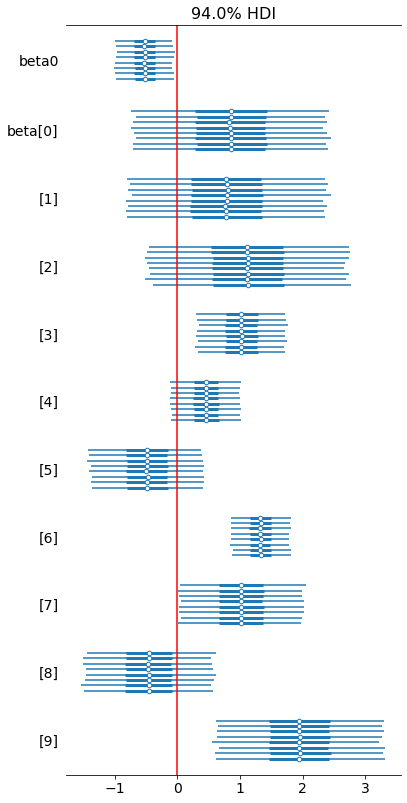

In [ ]:
# forest plots 
plt.figure(figsize=(6,14))
with cancer_simple_model:
  az.plot_forest(trace_simple, var_names=['beta0','beta'])
  plt.axvline(color='r', linestyle='-')

In [ ]:
pd.DataFrame(X_simple.columns)

,0
0,radius_mean
1,perimeter_mean
2,area_mean
3,smoothness_mean
4,symmetry_mean
5,fractal_dimension_mean
6,texture_mean
7,concavity_mean
8,compactness_mean
9,concave points_mean


Improved uncertainty as shown by the credible intervals of this model compared to the full model.

### **Model 3**: removing the insignificant predictors and selected four predictors

In [ ]:
X3 = X[['smoothness_mean','texture_mean','concavity_mean', 'concave points_mean']]

k3 = X3.shape[1]

pd.DataFrame(X3)

,smoothness_mean,texture_mean,concavity_mean,concave points_mean
149,-1.204139,-0.321053,-0.753164,-0.919018
124,-1.794101,-0.674768,-0.098925,-0.539588
421,0.479635,-1.235591,0.705598,0.363201
195,-1.206274,-0.688730,-0.628619,-0.648697
545,-0.277565,0.916946,-0.741488,-0.631673
...,...,...,...,...
71,0.104593,-1.082004,-0.034392,-0.521016
106,1.269571,-0.223317,-0.227236,-0.362899
270,-2.282296,-0.574704,-1.023849,-1.100607
435,0.686015,0.076875,0.298817,0.405245


In [ ]:
with pm.Model() as model3:

  data3 = pm.Data('data3', X3)

  beta0 = pm.Normal('beta0', mu=0, sd=10)
  beta = pm.MvNormal('beta', mu=np.zeros(k3), cov=np.eye(k3), shape=k3)

  mu = beta0 + pm.math.dot(data3, beta)
  theta = pm.Deterministic('theta', pm.invlogit(mu))

  Y = pm.Bernoulli('Y', p=theta, observed=y)

  trace3 = pm.sample(10000, cores=8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  del sys.path[0]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [beta, beta0]


Sampling 8 chains for 1_000 tune and 10_000 draw iterations (8_000 + 80_000 draws total) took 242 seconds.


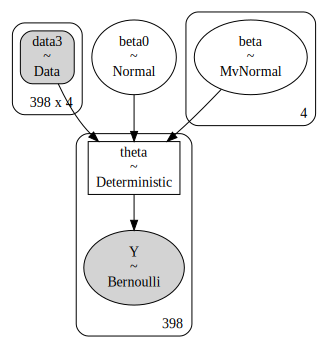

In [ ]:
pm.model_to_graphviz(model3)

In [ ]:
with model3:
  model3_idata = az.from_pymc3(trace3)
az.summary(model3_idata, var_names=['beta0','beta'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-0.60,0.19,-0.96,-0.23,0.0,0.0,69976.05,57458.04,1.0
beta[0],-0.28,0.24,-0.72,0.17,0.0,0.0,68287.32,54534.00,1.0
beta[1],1.04,0.21,0.66,1.45,0.0,0.0,71224.54,58863.26,1.0
beta[2],-0.24,0.36,-0.94,0.44,0.0,0.0,62178.35,56077.04,1.0
beta[3],4.25,0.51,3.28,5.18,0.0,0.0,59436.91,53517.75,1.0


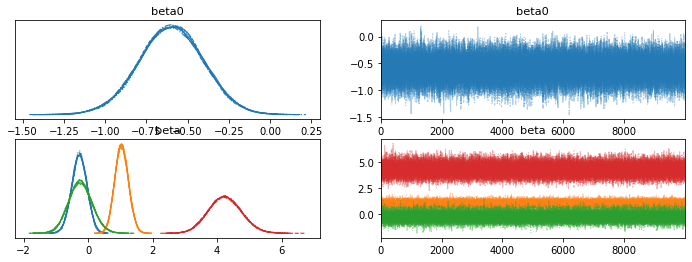

In [ ]:
# trace plots
with model3:
  az.plot_trace(trace3, var_names=['beta0','beta'])

<Figure size 432x1008 with 0 Axes>

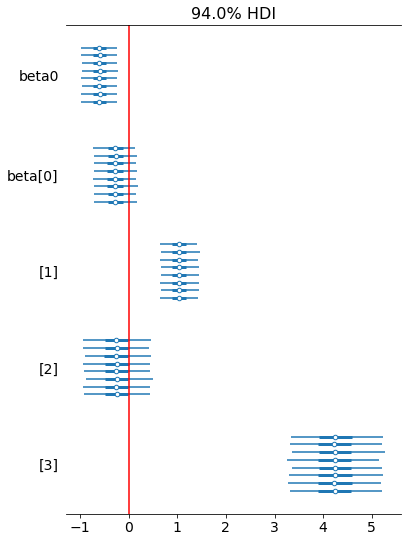

In [ ]:
# forest plots 
plt.figure(figsize=(6,14))
with model3:
  az.plot_forest(trace3, var_names=['beta0','beta'])
  plt.axvline(color='r', linestyle='-')

### Calculate the WAIC for each model

In [ ]:
cmp_cancer = az.compare({'main_model':trace_main, 'model_2':trace_simple, 'model_3':trace3}, 
                        ic='WAIC', scale='deviance')
cmp_cancer

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:1460: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future releas

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
main_model,0,64.969534,8.124594,0.000000,9.855730e-01,15.415355,0.000000,True,deviance
model_2,1,129.078966,6.388351,64.109432,6.999420e-12,17.576944,12.569693,True,deviance
model_3,2,152.918930,4.038295,87.949396,1.442696e-02,17.357042,16.024683,True,deviance


In [ ]:
# Use WAIC to produce a Bayesian model average result. 

pred_main = pm.sample_posterior_predictive_w(traces=[trace_main], samples=10000,
                                             models=[cancer_model])
pred_simple = pm.sample_posterior_predictive_w(traces=[trace_simple], samples=10000,
                                               models=[cancer_simple_model])
pred_3 = pm.sample_posterior_predictive_w(traces=[trace3], samples=10000,
                                             models=[model3])
pred_bma = pm.sample_posterior_predictive_w(traces=[trace_main, trace_simple, trace3],
                                            samples=10000, models=[cancer_model, cancer_simple_model,
                                                                   model3],
                                            weights=cmp_cancer['weight'])

**Kernel density plots of sample posterior predictions for each model and the BMA model**

<Figure size 1440x1080 with 0 Axes>

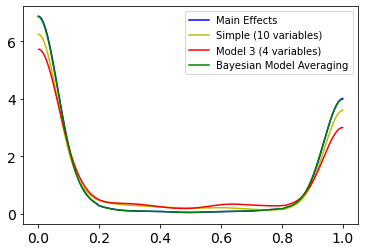

In [ ]:
models = [pred_main, pred_simple, pred_3, pred_bma]
colors = ['b', 'y', 'r', 'g']

# Show the kernel density plots for the sample posterior predictions of each of the models and the Bayesian model average.

plt.figure(figsize=(20,15))
fig, ax=plt.subplots()

labels = ['Main Effects', 'Simple (10 variables)', 'Model 3 (4 variables)', 'Bayesian Model Averaging']

for i, preds in enumerate(models):
  az.plot_kde(preds['Y'].mean(0), plot_kwargs={'color':colors[i]},label=labels[i], ax=ax)

plt.show()

**Predicting with Bayesian Logistic Regression**

In [ ]:
with cancer_model:
    pm.set_data({"data": test_X})
    post_pred = pm.sample_posterior_predictive(trace_main, samples=1000)

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [ ]:
p_test_pred = post_pred["Y"].mean(axis=0)
y_test_pred = (p_test_pred >= 0.5).astype("int")

**Full Model: Prediction Results** 

In [ ]:
from sklearn.metrics import accuracy_score

print(f"accuracy = {accuracy_score(y_true=test_y, y_pred=y_test_pred): 0.3f}")

accuracy =  0.994


In [ ]:
sklearn.metrics.confusion_matrix(test_y,y_test_pred )

array([[108,   0],
       [  1,  62]])

In [ ]:
test_X2 = test_X[['radius_mean','perimeter_mean','area_mean','smoothness_mean',
                   'symmetry_mean', 'fractal_dimension_mean', 'texture_mean', 'concavity_mean', 
                   'compactness_mean', 'concave points_mean']]

In [ ]:
with cancer_simple_model:
    pm.set_data({"data2": test_X2})
    post_pred = pm.sample_posterior_predictive(trace_simple, samples=1000)

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [ ]:
p_test_pred = post_pred["Y"].mean(axis=0)
y_test_pred = (p_test_pred >= 0.5).astype("int")

**Model 2: Prediction Results**

In [ ]:
from sklearn.metrics import accuracy_score

print(f"accuracy = {accuracy_score(y_true=test_y, y_pred=y_test_pred): 0.3f}")

accuracy =  0.942


In [ ]:
sklearn.metrics.confusion_matrix(test_y,y_test_pred)

array([[104,   4],
       [  6,  57]])

In [ ]:
test_X3 = test_X[['smoothness_mean','texture_mean','concavity_mean', 'concave points_mean']]

In [ ]:
with model3:
    pm.set_data({"data3": test_X3})
    post_pred = pm.sample_posterior_predictive(trace3, samples=1000)

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [ ]:
p_test_pred = post_pred["Y"].mean(axis=0)
y_test_pred = (p_test_pred >= 0.5).astype("int")

**Model 3: Prediction Results**

In [ ]:
from sklearn.metrics import accuracy_score

print(f"accuracy = {accuracy_score(y_true=test_y, y_pred=y_test_pred): 0.3f}")

accuracy =  0.912


In [ ]:
sklearn.metrics.confusion_matrix(test_y,y_test_pred)

array([[101,   7],
       [  8,  55]])

Classic Logistic Regression

In [ ]:
test_y.shape

(171,)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X, y)

LogisticRegression()

In [ ]:
y_pred = logreg.predict(test_X)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test_X, test_y)))

Accuracy of logistic regression classifier on test set: 0.98


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_y, y_pred)
print(confusion_matrix)


[[106   2]
 [  1  62]]
